In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import os
import sys
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt
# path='your/path/before/islbbnn/folder'
path='../../'
os.chdir(path)
current_dir = os.getcwd()
sys.path.append('islbbnn')
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('islbbnn/networks')
from ann_net import NeuralNet
os.chdir(current_dir) # set the working directory back to this one 

In [2]:
device = torch.device("cpu")

# Helper classes

## LIME

In [3]:
# Assuming `net` is your trained PyTorch model and `device` is your computation device (e.g., 'cpu' or 'cuda')
class LIMEexplainer:
    def __init__(self, net, device):
        self.net = net
        self.device = device


    def batch_predict_lime(self, x):
        self.net.eval()
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        if len(x.shape) == 1:
            preds = np.zeros((1000, 1, 2))
        else:
            preds = np.zeros((1000, len(x), 2))
        with torch.no_grad():
            for samp in range(len(preds)):
                preds[samp, :, 1] = self.net.mpm(x).detach().cpu().numpy().T[0]
                preds[samp, :, 0] = 1 - preds[samp, :, 1]
        preds = preds.mean(0)
        return preds

    def explain_lime(self, X_train, explain_this, feature_names, class_names, num_samples=2_000):
        # Assuming `X_train` is your training data and `class_names` are the names of the classes
        explainer = LimeTabularExplainer(
            training_data=X_train,
            feature_names=feature_names,
            class_names=class_names,
            mode='classification'
        )
        # Explain a single instance
        exp = explainer.explain_instance(
            data_row=explain_this,
            predict_fn=self.batch_predict_lime,
            num_features=len(feature_names),  # Number of features to include in the explanation
            num_samples=num_samples
        )
        return exp


    def plot_lime_explain(self, exp, names_features, explain_this=None, magnitude=False,  class_label=1):
        # Extract feature importances for a specific class
        feature_importances = dict(exp.as_map()[class_label])

        # Ensure the feature importances are in the correct order
        ordered_importances = np.array([feature_importances[indx] for indx in range(len(names_features))])
        if magnitude:
            ordered_importances /= explain_this
        # Create a bar plot
        plt.figure(figsize=(10, 6))
        plt.bar(names_features, ordered_importances, color='skyblue', edgecolor='k')
        plt.ylabel('LIME importance')
        plt.xlabel('Feature')
        plt.title(f'LIME feature importances for Class {class_label}')
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()

## SHAP

In [4]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')
class SHAPexplainer:
    def __init__(self, net, device):
        self.net = net
        self.device = device
    def batch_predict_shap(self, x):
        self.net.eval()
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        preds = np.zeros((1000, len(x), 1))
        with torch.no_grad():
            for samp in range(len(preds)):
                preds[samp, :, 0] = self.net.mpm(x).detach().cpu().numpy().T[0]
        preds = preds.mean(0)
        return preds


    def shap_explain(self, X_train, explain_this, max_evals=1_000, batch_size=256):
        # Create SHAP explainer
        explainer = shap.Explainer(self.batch_predict_shap, X_train)
        # Index of the instance you want to explain

        # Explain the instance
        shap_vals = explainer(explain_this, max_evals=max_evals, batch_size=batch_size)
        return shap_vals

    def plot_shap_explain(self, shap_vals, feature_names):
        # Plot bar plot of SHAP values
        plt.figure(figsize=(10, 6))
        plt.bar(feature_names, shap_vals.values[0], color='skyblue', edgecolor='k')
        plt.xlabel('Feature')
        plt.ylabel('SHAP value')
        plt.title(f'SHAP values with baseline of: {shap_vals.base_values[0][0]:.4f}')
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()

# Linear problem

In [5]:
net = torch.load('ann_implementation/network/net0_linear', weights_only=False).to(device)
net.eval()

NeuralNet(
  (linears): ModuleList(
    (0): Linear(in_features=5, out_features=20, bias=False)
    (1-3): 3 x Linear(in_features=25, out_features=20, bias=False)
    (4): Linear(in_features=25, out_features=1, bias=False)
  )
  (loss): BCELoss()
)

## Local contributions of a specific input

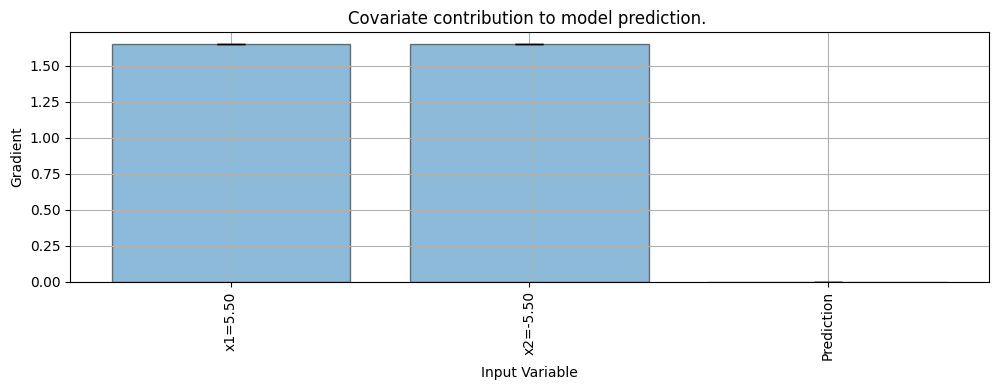

In [30]:
explain_this = torch.tensor([1.000, 5.50, -5.50, 10.0, -50.0])
pf.plot_local_explain_piecewise_linear_act(
    net, 
    explain_this, 
    n_samples=1, 
    magnitude=True, 
    include_prediction=True, 
    include_bias=True, 
    fig_size=(10,4), 
    no_zero_contributions=True, 
    ann=True, 
    save_path="ann_implementation/local_contributions/imgs/local_contribution_linear")

## Global explanation based on local contributions

In [6]:
n_samples = 10_000
n_expl_per_sample = 1

y, X = pip_func.create_data_unif(n_samples, beta=[100,1,1,1,1], dep_level=0.0, classification=True, non_lin=False)

data = torch.tensor(X,dtype = torch.float32)

contributions_lin = np.zeros((len(X), n_expl_per_sample, 5))
predictions = np.zeros((len(X), n_expl_per_sample))

for ind, d in enumerate(data):
    expl, preds, _ = pip_func.local_explain_piecewise_linear_act(net, d, n_samples=n_expl_per_sample)
    contributions_lin[ind] = expl[:,:,0]
    predictions[ind] = preds[:,0] > 0.5

/tmp/ipykernel_36073/2039900604.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predictions[ind] = preds[:,0] > 0.5


### Plot global explnation whole model

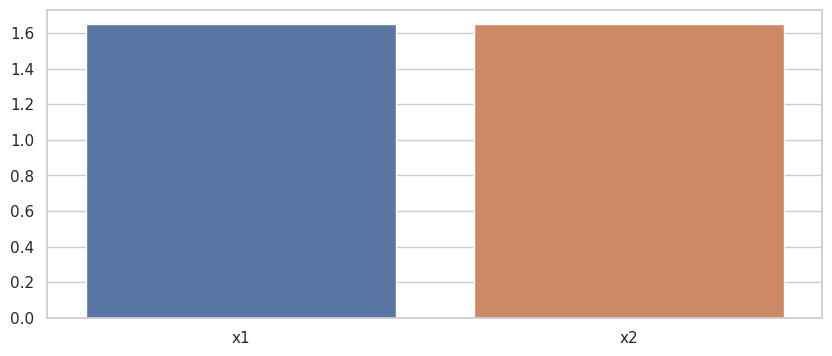

In [7]:
df = pd.DataFrame(contributions_lin.reshape(n_samples,-1), columns=["x0","x1","x2","x3","x4"])
plt.figure(figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(df.iloc[:,[1,2]])
plt.savefig("ann_implementation/local_contributions/imgs/global_explain_linear_local.png")
plt.show()

### Plot global explanation per class

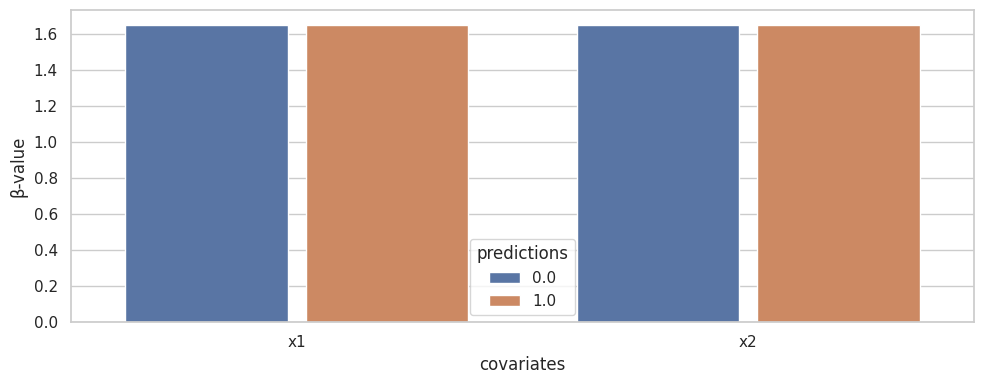

In [11]:
df = pd.DataFrame(contributions_lin.reshape(n_samples*n_expl_per_sample,-1), columns=["x0","x1","x2","x3","x4"])
# df["y"] = np.stack((y,)*n_expl_per_sample, axis=0).T.reshape(n_samples*n_expl_per_sample)
df["predictions"] = predictions.flatten()
dfm = df.iloc[:,[1,2,5]].melt('predictions',var_name='covariates', value_name='β-value')
plt.figure(figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(data=dfm, x='covariates', y='β-value', hue="predictions", gap=0.1)
plt.tight_layout()
plt.savefig("ann_implementation/local_contributions/imgs/global_explain_linear_per_class")
plt.show()

In [12]:
sns.reset_orig()
plt.clf()
plt.close()

## LIME and SHAP explanation

### LIME

In [50]:
feature_names = ["bais", "x1", "x2", "x3", "x4"]


lime_exp = LIMEexplainer(net, device)
exp = lime_exp.explain_lime(X, explain_this.detach().numpy(), feature_names=feature_names, class_names=["Class 0", "Class 1"])

In [51]:
exp.as_map()

{1: [(np.int64(2), np.float64(-0.5006891777160942)),
  (np.int64(1), np.float64(0.4916732657557834)),
  (np.int64(3), np.float64(-0.011615924625018675)),
  (np.int64(4), np.float64(0.003699477306046384)),
  (np.int64(0), np.float64(0.0))]}

Magnitude=True


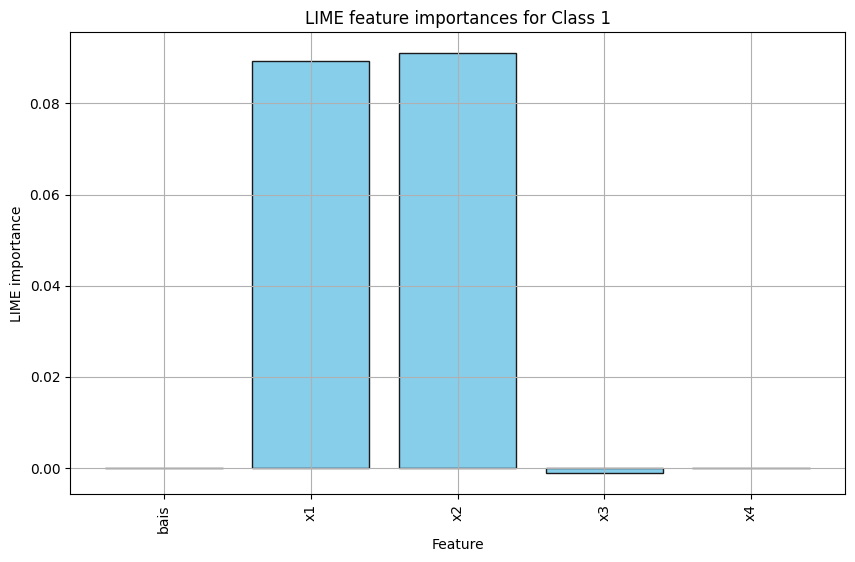

Magnitude=False


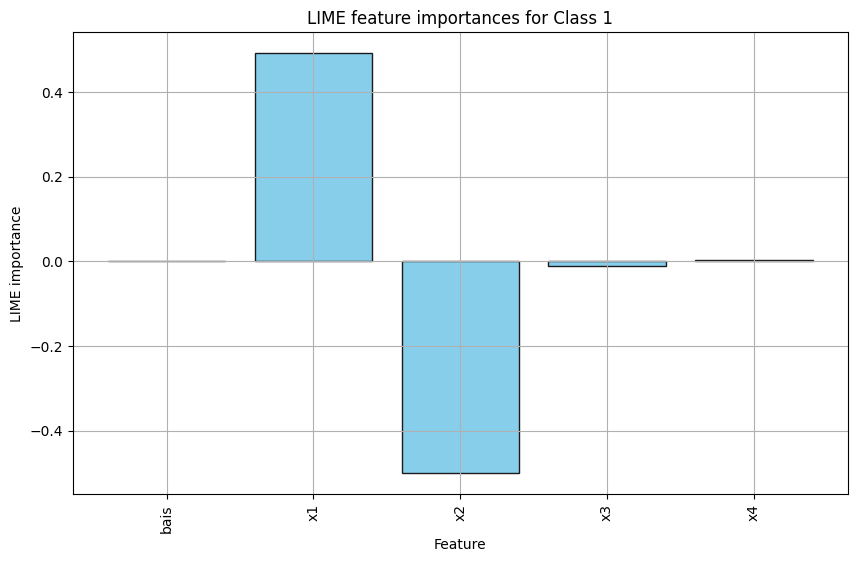

In [52]:
tf_list = [True, False]
for tf in tf_list:
    print(f"Magnitude={tf}")
    lime_exp.plot_lime_explain(exp, feature_names, explain_this=explain_this, magnitude=tf)

### SHAP

In [53]:
feature_names = ["bais", "x1", "x2", "x3", "x4"]


shap_exp = SHAPexplainer(net, device)
exp = shap_exp.shap_explain(X, explain_this.detach().numpy().reshape(-1,explain_this.shape[0]))

In [54]:
exp

.values =
array([[ 0.00000000e+00,  2.83128538e-01, -2.27601644e-01,
         1.38777878e-17,  0.00000000e+00]])

.base_values =
array([[0.44462379]])

.data =
array([[  1. ,   5.5,  -5.5,  10. , -50. ]], dtype=float32)

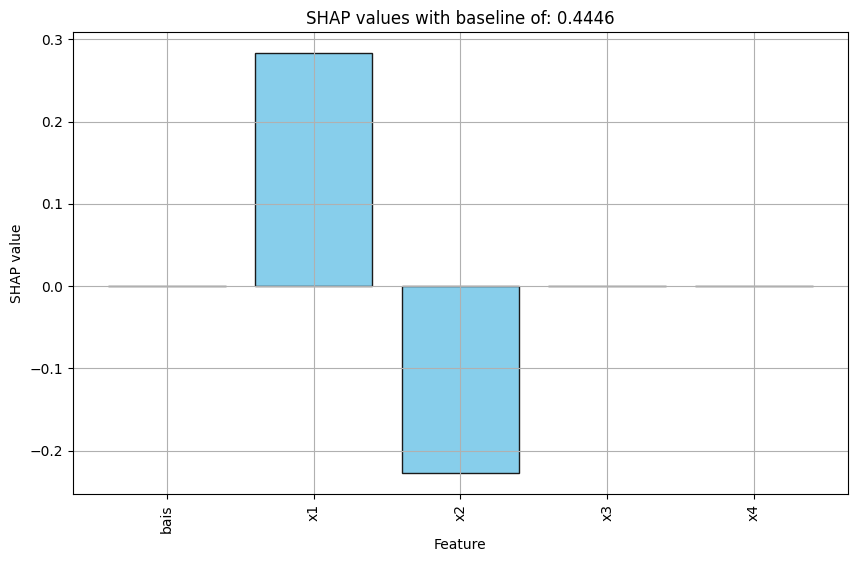

In [55]:
shap_exp.plot_shap_explain(exp, feature_names)

# Non-linear problem

In [13]:
net = torch.load('ann_implementation/network/net1_non_linear', weights_only=False).to(device)
net.eval()

NeuralNet(
  (linears): ModuleList(
    (0): Linear(in_features=5, out_features=20, bias=False)
    (1-3): 3 x Linear(in_features=25, out_features=20, bias=False)
    (4): Linear(in_features=25, out_features=1, bias=False)
  )
  (loss): BCELoss()
)

In [11]:
import importlib
importlib.reload(pip_func)
importlib.reload(pf)

<module 'plot_functions' from '/home/eirik/projects/Interpretable-NNs/islbbnn/plot_functions.py'>

## Local contributions for a specific input

Magnitude=True


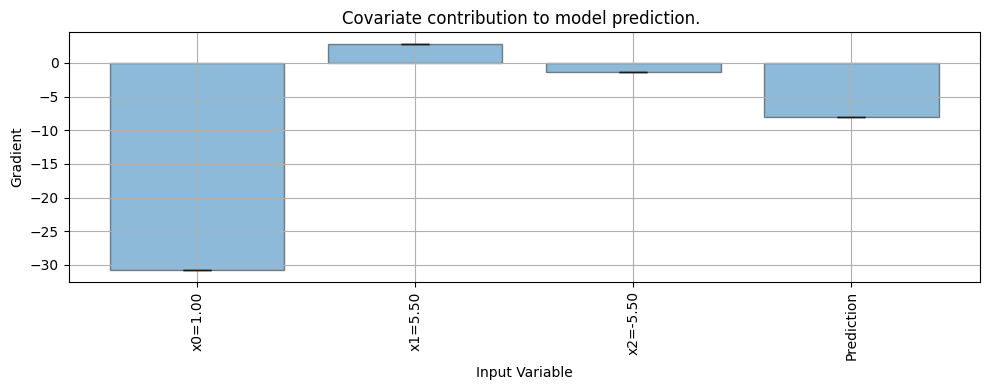

Magnitude=False


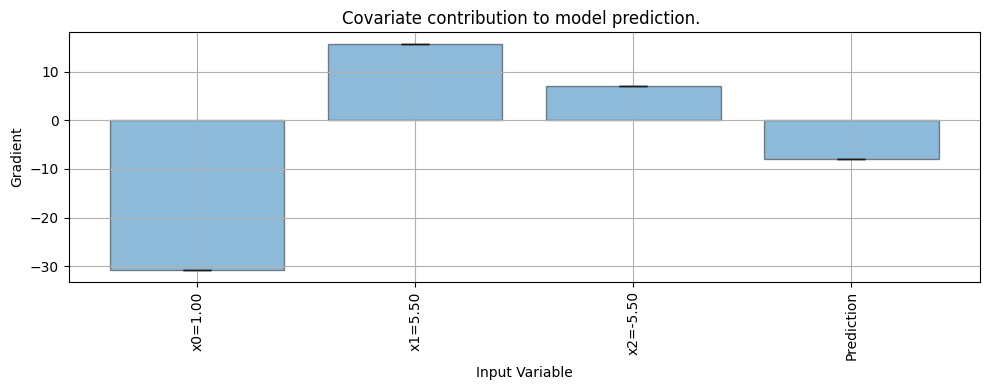

In [35]:
explain_this = torch.tensor([1.000, 5.50, -5.50, 10.0, -50.0])
tf_list = [True, False]
for tf in tf_list:
    print(f"Magnitude={tf}")
    pf.plot_local_explain_piecewise_linear_act(
        net, 
        explain_this, 
        n_samples=1, 
        magnitude=tf, 
        include_prediction=True, 
        include_bias=True, 
        fig_size=(10,4), 
        no_zero_contributions=True, 
        ann=True, 
        save_path=f"ann_implementation/local_contributions/imgs/local_contribution_non_linear_magnitude={tf}_test")

## Global explanation based on local contributions

In [14]:
n_samples = 10_000
n_expl_per_sample = 1

y, X = pip_func.create_data_unif(n_samples, beta=[100,1,1,1,1], dep_level=0.0, classification=True, non_lin=True)

data = torch.tensor(X,dtype = torch.float32)

contributions_non_lin = np.zeros((len(X), n_expl_per_sample, 5))
predictions = np.zeros((len(X), n_expl_per_sample))

for ind, d in enumerate(data):
    expl, preds, _ = pip_func.local_explain_piecewise_linear_act(net, d, n_samples=n_expl_per_sample)
    contributions_non_lin[ind] = expl[:,:,0]
    predictions[ind] = preds[:,0] > 0.5

/tmp/ipykernel_36073/850774947.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predictions[ind] = preds[:,0] > 0.5


### Plot global explanation whole model

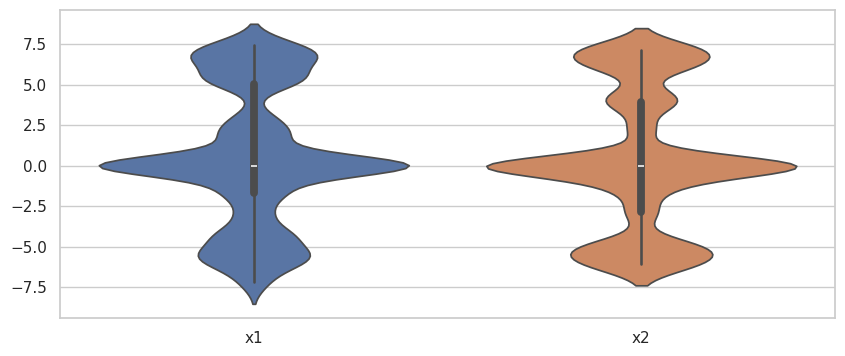

In [ ]:
df = pd.DataFrame(contributions_non_lin.reshape(n_samples,-1), columns=["x0","x1","x2","x3","x4"])
plt.figure(figsize=(10,4))
sns.set(style="whitegrid")
sns.violinplot(df.iloc[:,[1,2]])
plt.savefig("ann_implementation/local_contributions/imgs/global_explain_non_linear.png")
plt.show()

### Plot global explanation per class

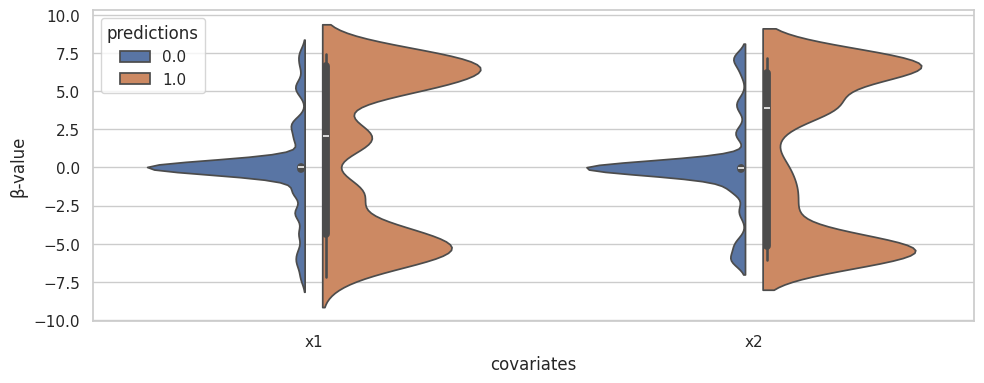

In [17]:
df = pd.DataFrame(contributions_non_lin.reshape(n_samples*n_expl_per_sample,-1), columns=["x0","x1","x2","x3","x4"])
# df["y"] = np.stack((y,)*n_expl_per_sample, axis=0).T.reshape(n_samples*n_expl_per_sample)
df["predictions"] = predictions.flatten()
dfm = df.iloc[:,[1,2,5]].melt('predictions',var_name='covariates', value_name='β-value')
plt.figure(figsize=(10,4))
sns.set(style="whitegrid")
sns.violinplot(data=dfm, x='covariates', y='β-value', hue="predictions", split=True, gap=0.1)
plt.tight_layout()
plt.savefig("ann_implementation/local_contributions/imgs/global_explain_non_linear_per_class")
plt.show()

In [18]:
sns.reset_orig()
plt.clf()
plt.close()

## LIME and SHAP explanation

In [19]:
feature_names = ["bais", "x1", "x2", "x3", "x4"]


lime_exp = LIMEexplainer(net, device)
exp = lime_exp.explain_lime(X, explain_this.detach().numpy(), feature_names=feature_names, class_names=["Class 0", "Class 1"])

In [20]:
exp.as_map()

{1: [(np.int64(3), np.float64(-0.0032434972309233175)),
  (np.int64(4), np.float64(-0.0032242247471284914)),
  (np.int64(1), np.float64(-0.00291246316616879)),
  (np.int64(2), np.float64(-0.002556907189405841)),
  (np.int64(0), np.float64(0.0))]}

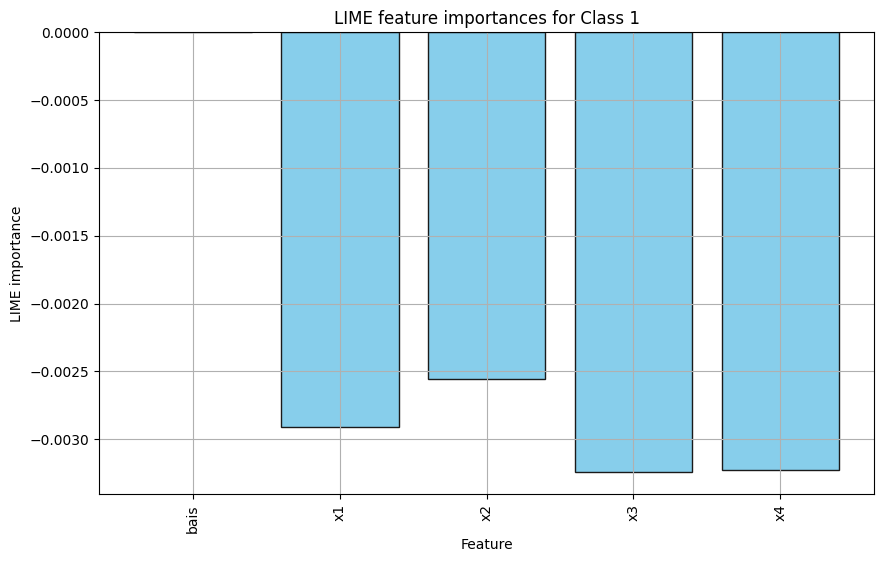

In [21]:
lime_exp.plot_lime_explain(exp, feature_names, explain_this=explain_this)

### SHAP

In [22]:
feature_names = ["bais", "x1", "x2", "x3", "x4"]


shap_exp = SHAPexplainer(net, device)
exp = shap_exp.shap_explain(X, explain_this.detach().numpy().reshape(-1,explain_this.shape[0]))

In [23]:
exp

.values =
array([[ 0.00000000e+00, -2.49279261e-01, -2.50318364e-01,
         1.38777878e-17,  0.00000000e+00]])

.base_values =
array([[0.4999357]])

.data =
array([[  1. ,   5.5,  -5.5,  10. , -50. ]], dtype=float32)

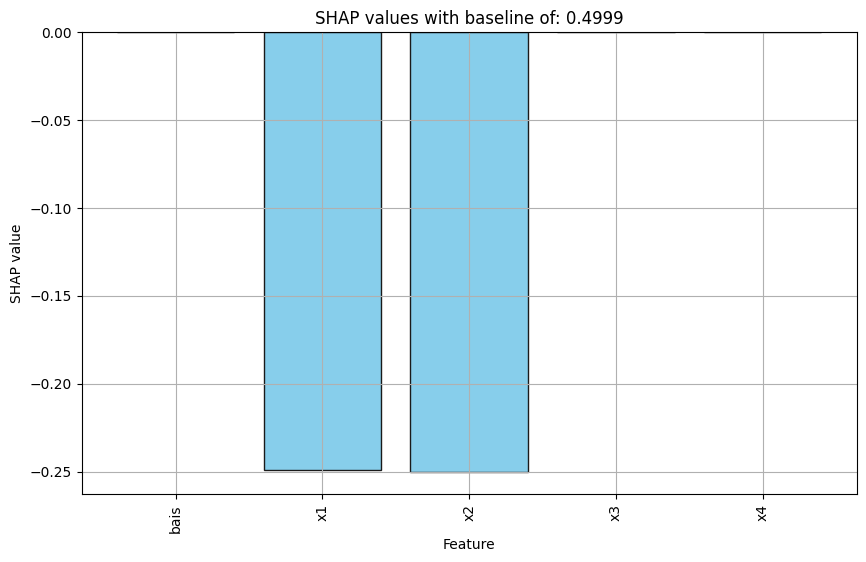

In [24]:
shap_exp.plot_shap_explain(exp, feature_names)